In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

file_path = '../data_preprocess/ketqua.csv'

data = pd.read_csv(file_path)
data.head()

,Giá,Diện tích,Số phòng,Quận
0,7.00,89.0,2.0,Quận Nam Từ Liêm
1,2.80,48.0,2.0,Quận Tây Hồ
2,3.65,73.0,2.0,Quận Long Biên
3,9.60,104.0,3.0,Quận Nam Từ Liêm
4,6.70,108.0,3.0,Quận Cầu Giấy


1. Remove records with missing fields
2. Remove outliers (data with price > 300)

In [64]:
price_field_name = 'Giá'
area_field_name = 'Diện tích'
district_field_name = 'Quận'
num_room_field_name = 'Số phòng'

data = data.dropna(subset=['Giá', 'Diện tích', 'Quận', 'Số phòng'])
data = data[(data['Giá'] < 200)]


In [65]:
# Tính IQR
# Tính IQR cho các cột số
num_columns = ['Giá', 'Diện tích', 'Số phòng']  # chỉ định các cột là số
Q1 = data[num_columns].quantile(0.25)
Q3 = data[num_columns].quantile(0.75)
IQR = Q3 - Q1

# Định nghĩa outliers và lọc dữ liệu
# Chỉ áp dụng các điều kiện lọc cho các cột số
is_outlier = ((data[num_columns] < (Q1 - 1.5 * IQR)) | (data[num_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
data = data[~is_outlier]

# In ra để kiểm tra kết quả sau khi loại bỏ outliers
print(data.head())


    Giá  Diện tích  Số phòng              Quận
0  7.00       89.0       2.0  Quận Nam Từ Liêm
1  2.80       48.0       2.0       Quận Tây Hồ
2  3.65       73.0       2.0    Quận Long Biên
3  9.60      104.0       3.0  Quận Nam Từ Liêm
4  6.70      108.0       3.0     Quận Cầu Giấy


Plot graph for each district

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_price_by_area_rooms(district_name=False):
    # Lọc dữ liệu cho quận cụ thể
    if not district_name:
        district_data = data
    else:
        district_data = data[data['Quận'] == district_name]
    
    # Vẽ biểu đồ phân tán giá theo diện tích và số phòng
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(district_data['Diện tích'], district_data['Giá'], c=district_data['Số phòng'], cmap='viridis', alpha=0.6, edgecolors='w')
    plt.title(f'Biểu đồ Phân tán Giá theo Diện tích và Số Phòng - {district_name}')
    plt.xlabel('Diện tích (m²)')
    plt.ylabel('Giá (VND)')
    plt.colorbar(scatter, label='Số phòng')
    plt.show()


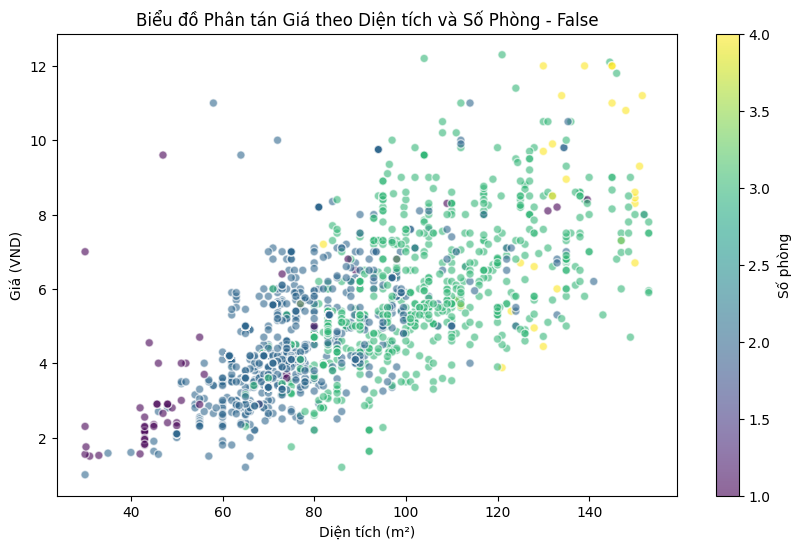

In [85]:
plot_price_by_area_rooms()

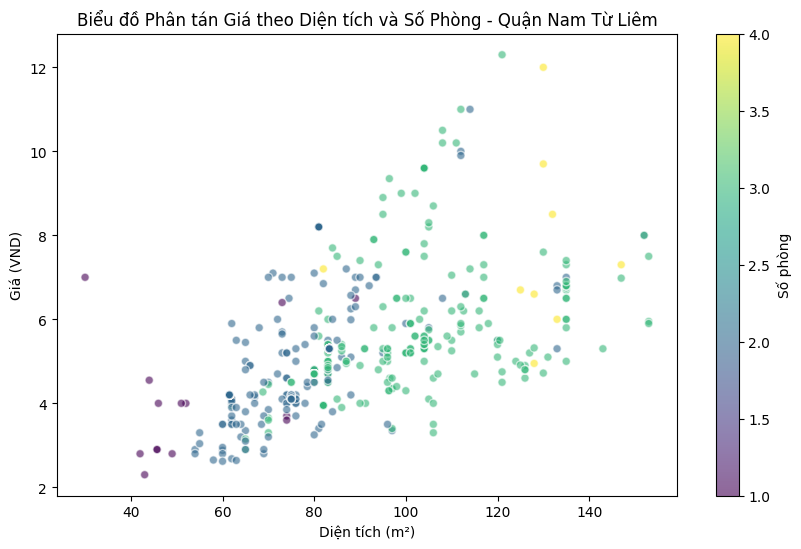

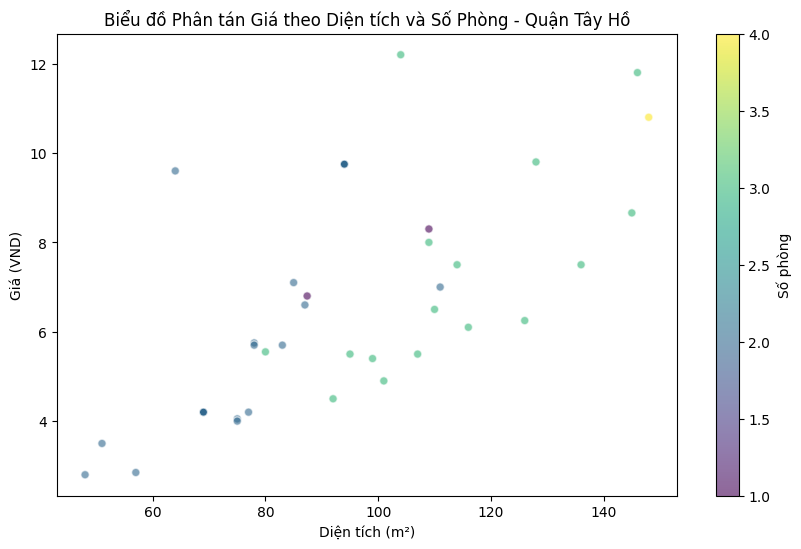

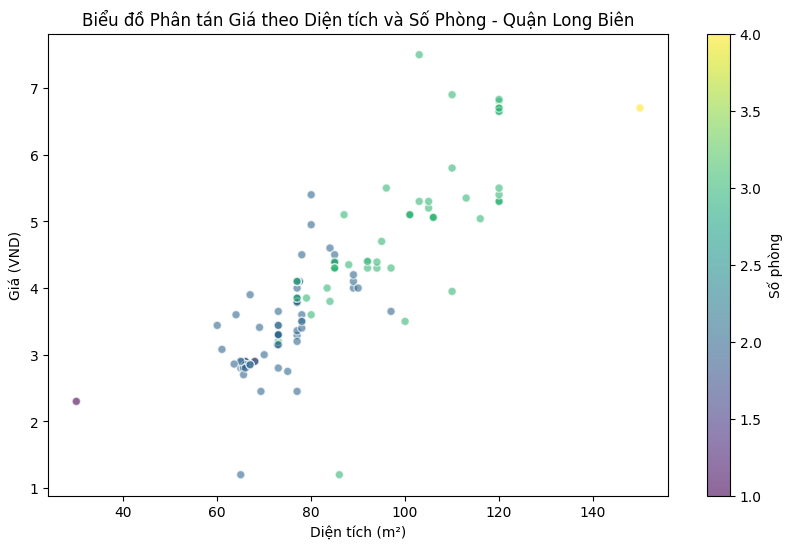

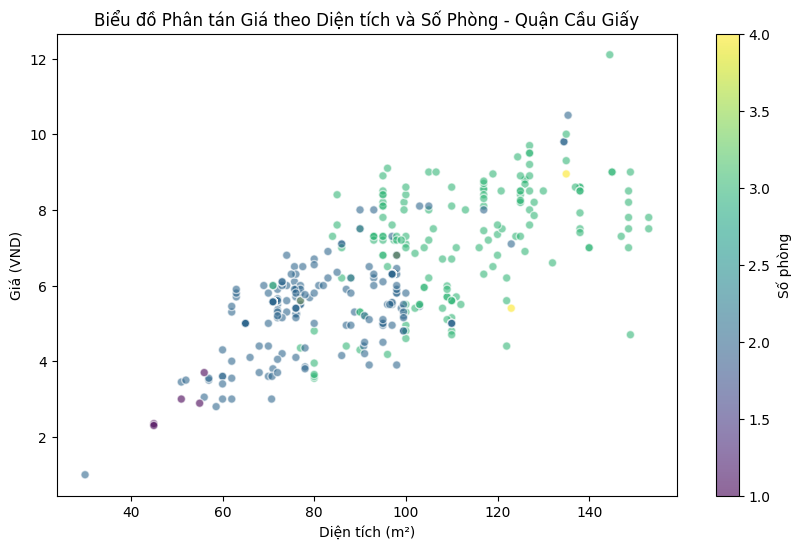

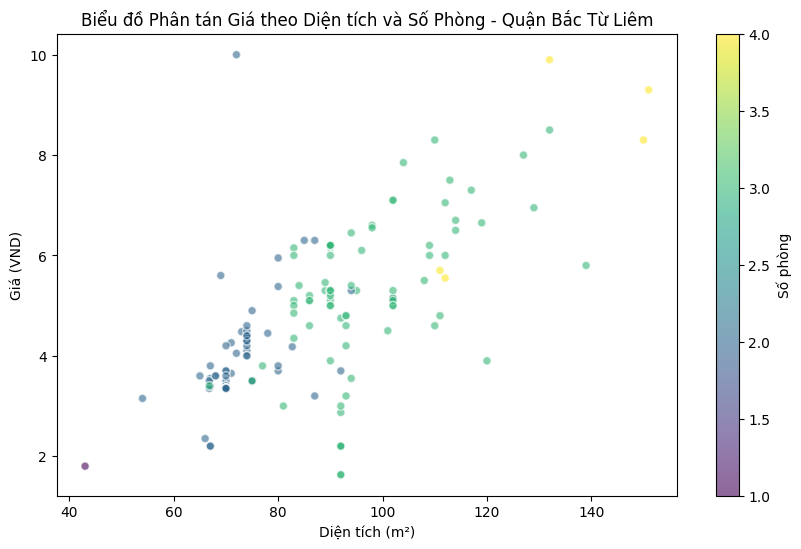

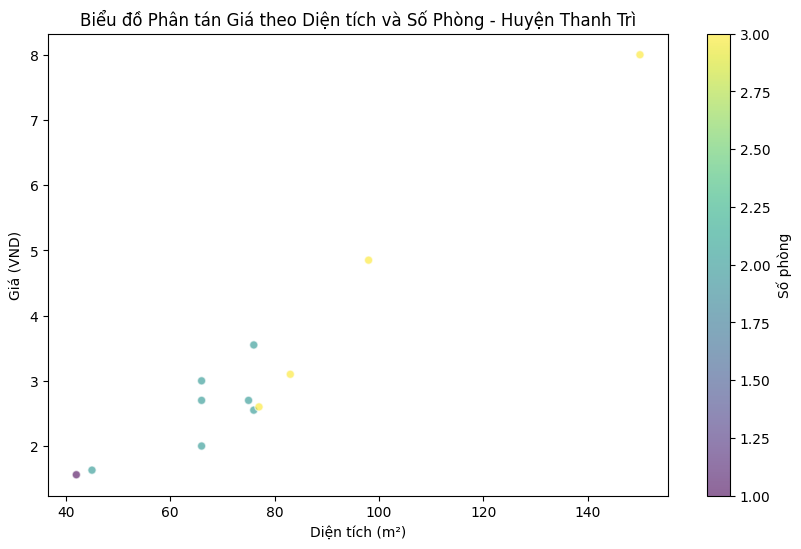

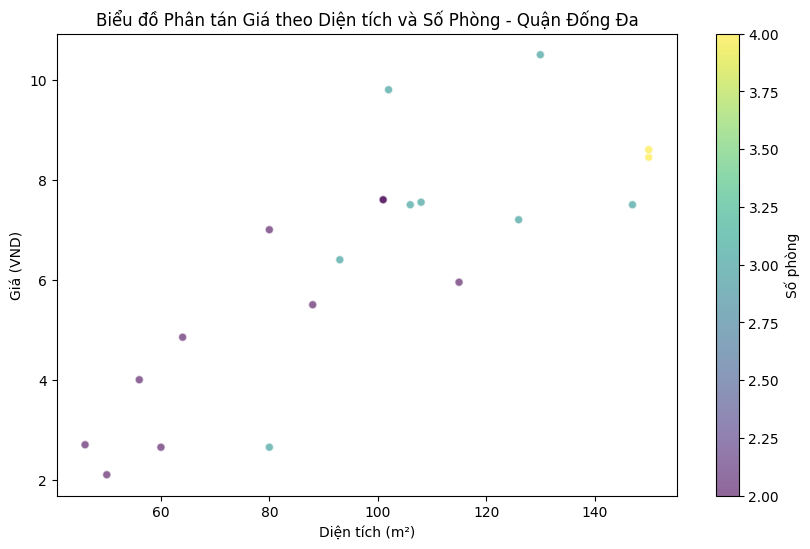

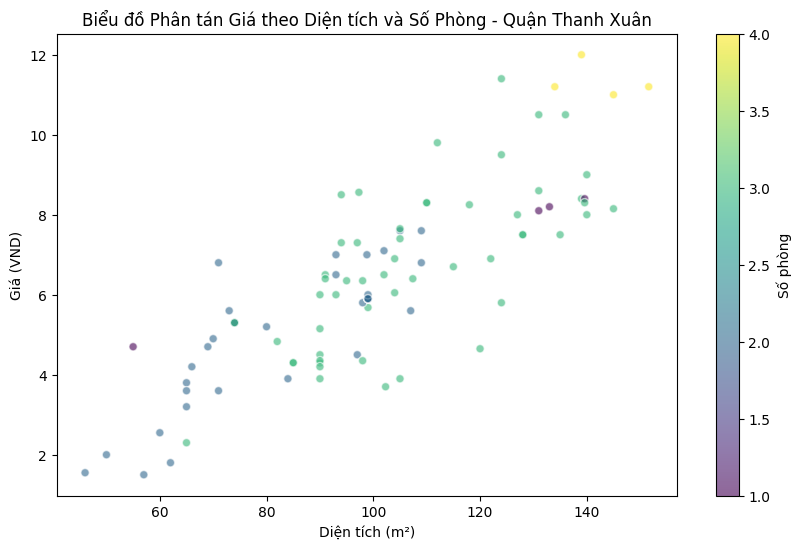

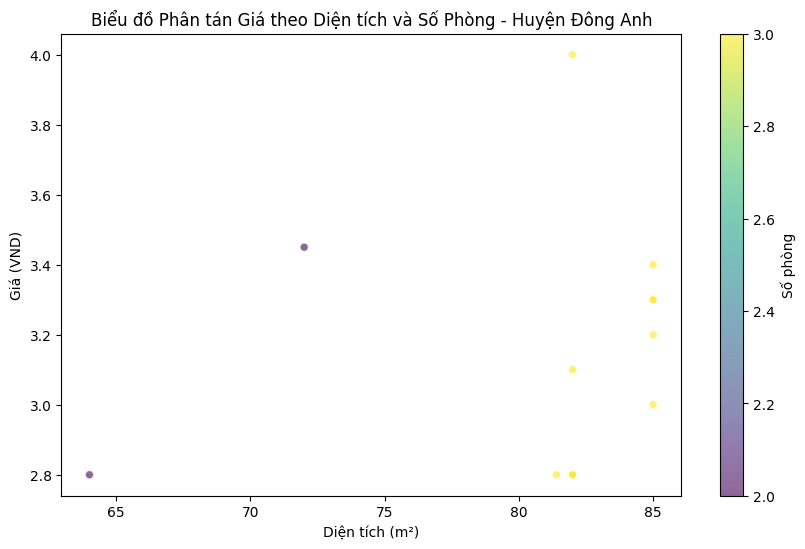

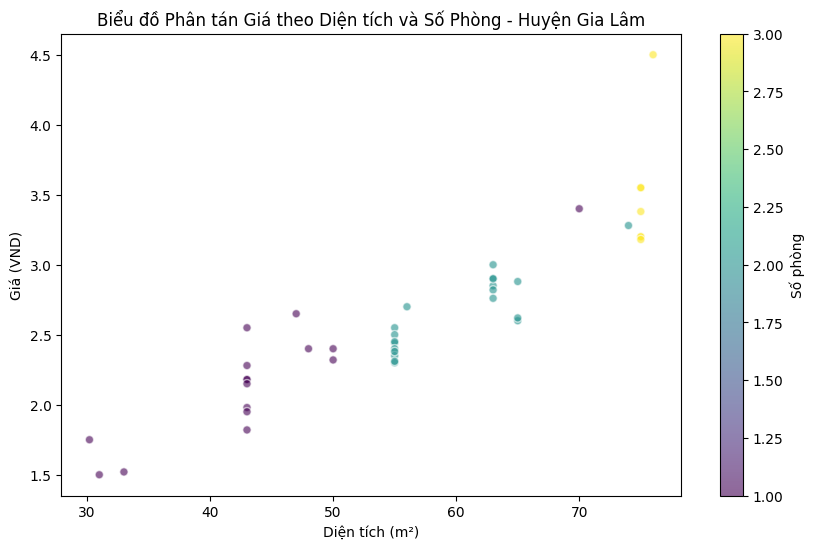

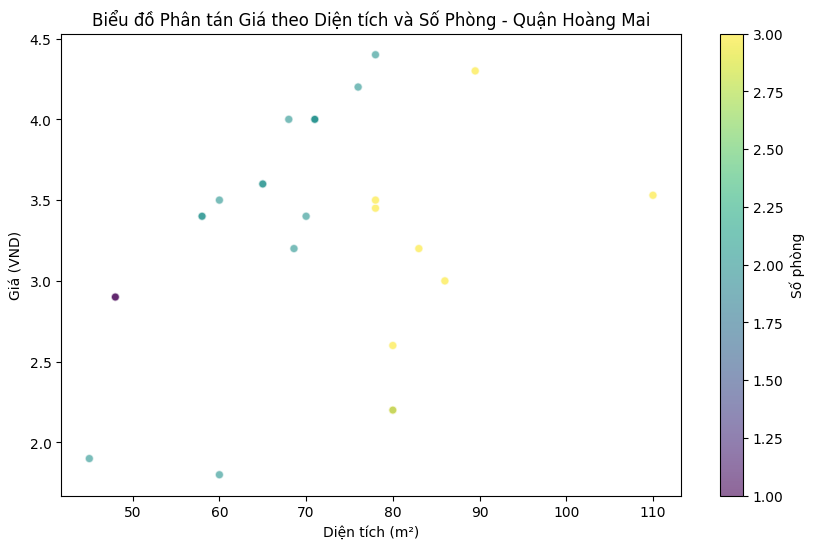

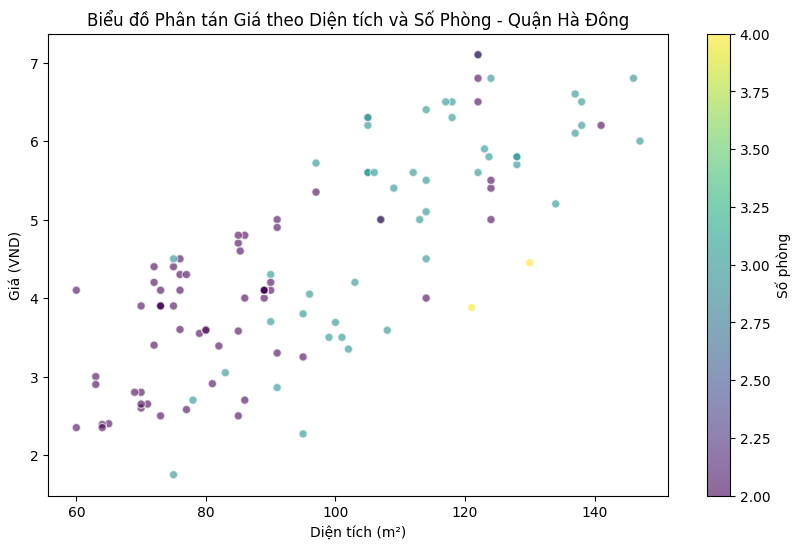

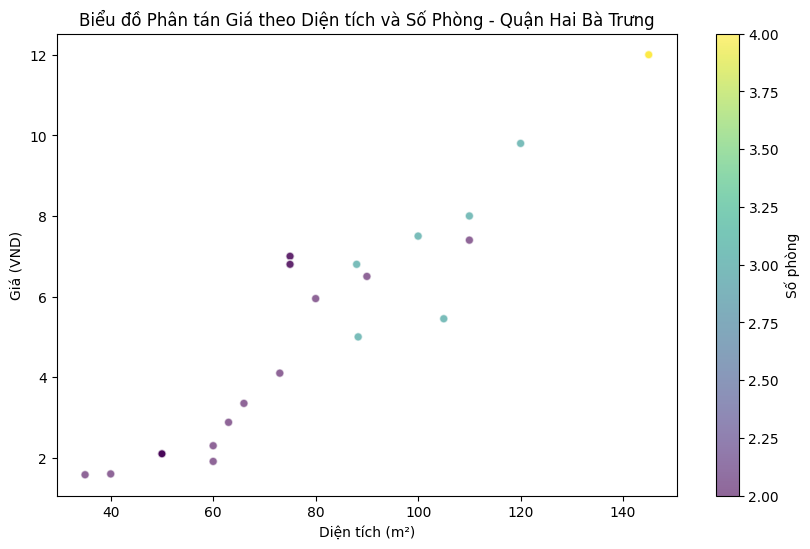

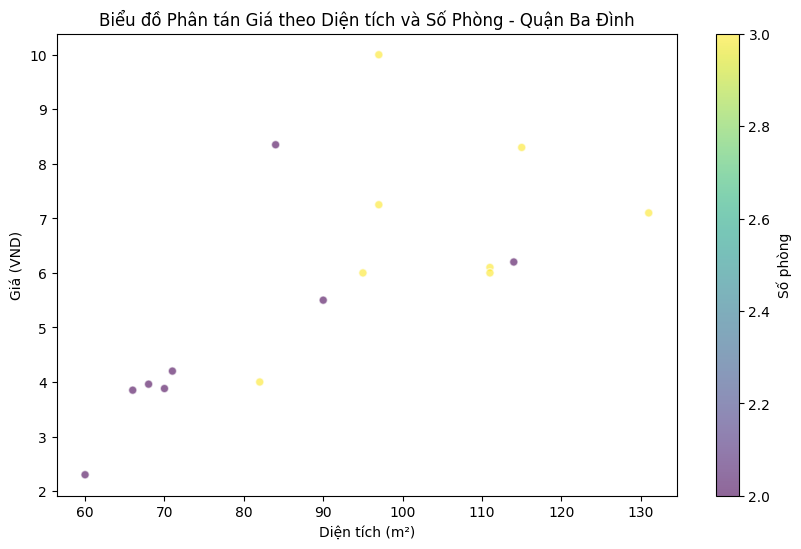

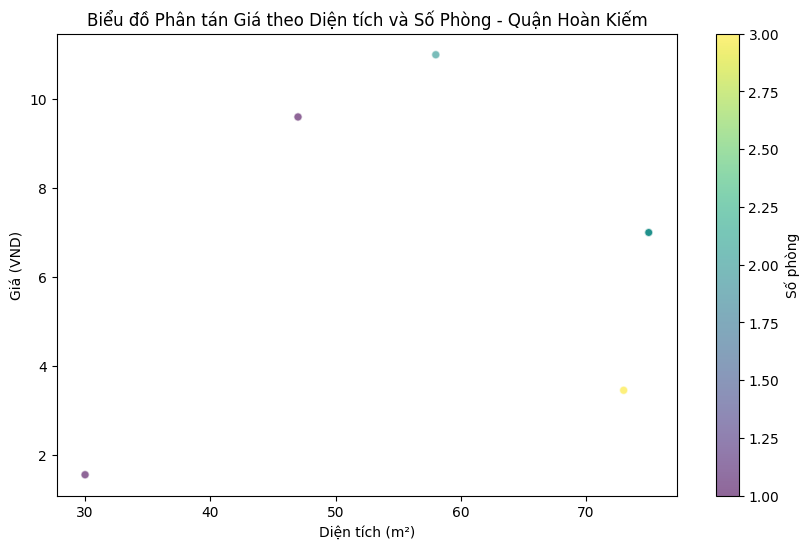

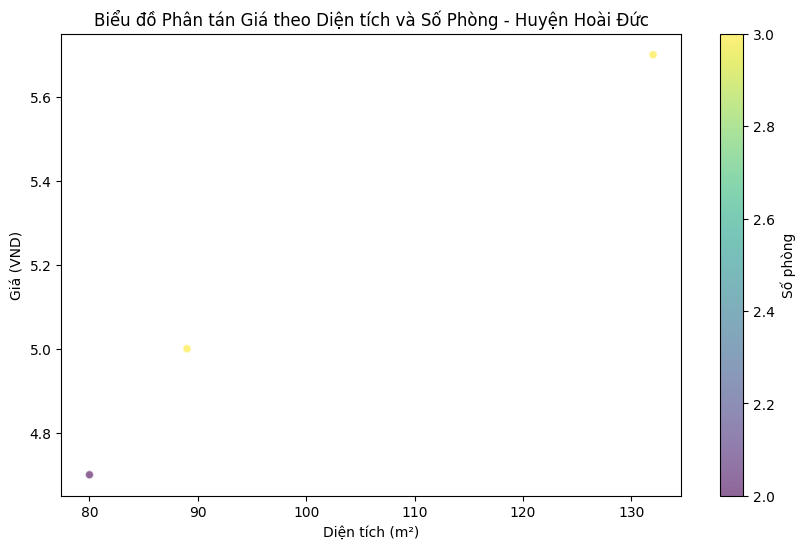

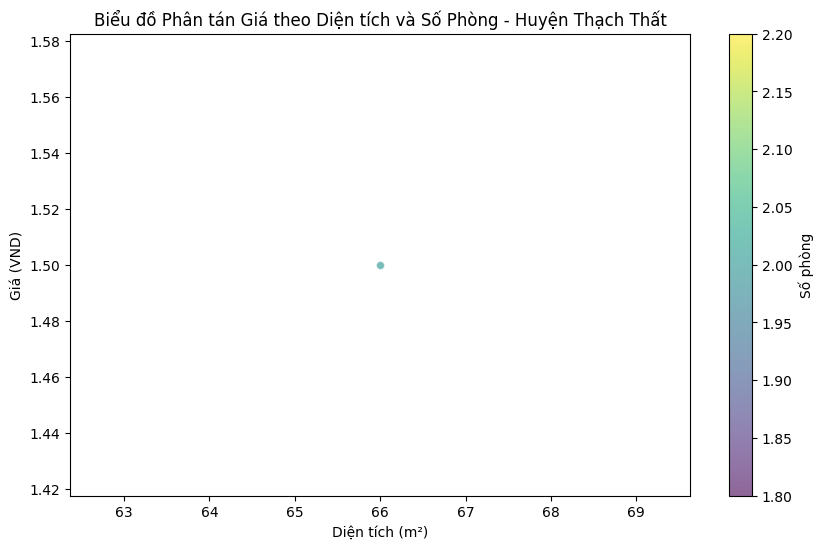

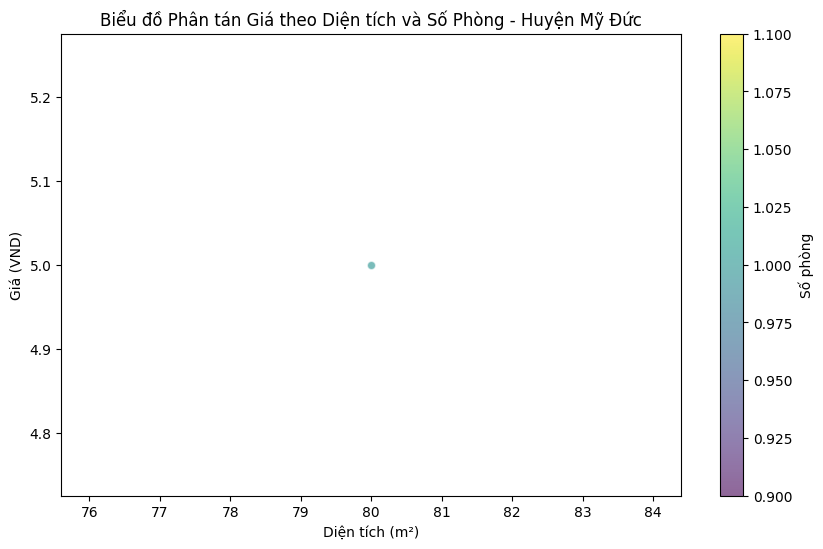

In [67]:
# Vòng lặp qua mỗi quận duy nhất trong DataFrame
for district in data['Quận'].unique():
    plot_price_by_area_rooms(district)


In [68]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import train_test_split

models = {}
model_metrics = {}

for district in data['Quận'].unique():
    district_data = data[data['Quận'] == district]
    
    if len(district_data) >= 10:
        X = district_data[['Diện tích', 'Số phòng']]
        y = district_data['Giá']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        model = HuberRegressor()
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        models[district] = model
        model_metrics[district] = {'RMSE': mse ** 0.5, 'R-squared': r2}
    else:
        print(f"Quận {district} không đủ dữ liệu để huấn luyện mô hình.")

# Sắp xếp quận theo R-squared và lấy top 5
top_districts = sorted(model_metrics, key=lambda x: model_metrics[x]['R-squared'], reverse=True)[:5]

print("Top 5 quận có mô hình tốt nhất:")
for district in top_districts:
    metrics = model_metrics[district]
    print(f"{district}: R-squared = {metrics['R-squared']:.2f}, RMSE = {metrics['RMSE']:.2f}")

Quận Huyện Hoài Đức không đủ dữ liệu để huấn luyện mô hình.
Quận Huyện Thạch Thất không đủ dữ liệu để huấn luyện mô hình.
Quận Huyện Mỹ Đức không đủ dữ liệu để huấn luyện mô hình.
Top 5 quận có mô hình tốt nhất:
Huyện Gia Lâm: R-squared = 0.92, RMSE = 0.18
Quận Hai Bà Trưng: R-squared = 0.85, RMSE = 1.09
Quận Tây Hồ: R-squared = 0.82, RMSE = 1.12
Quận Hoàn Kiếm: R-squared = 0.81, RMSE = 1.11
Quận Long Biên: R-squared = 0.79, RMSE = 0.42


In [69]:
from sklearn.metrics import mean_squared_error, r2_score

# In thông số đánh giá cho mỗi mô hình
for district, model in models.items():
    district_data = data[data['Quận'] == district]
    X = district_data[['Diện tích', 'Số phòng']]
    y = district_data['Giá']

    # Dự đoán trên dữ liệu của quận
    y_pred = model.predict(X)

    mse = mean_squared_error(y, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y, y_pred)

    print(f"Thông số đánh giá mô hình cho {district}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"R-squared: {r2:.2f}")
    print("-" * 30)


Thông số đánh giá mô hình cho Quận Nam Từ Liêm:
RMSE: 1.72
MSE: 2.96
R-squared: 0.23
------------------------------
Thông số đánh giá mô hình cho Quận Tây Hồ:
RMSE: 1.57
MSE: 2.46
R-squared: 0.67
------------------------------
Thông số đánh giá mô hình cho Quận Long Biên:
RMSE: 0.59
MSE: 0.35
R-squared: 0.74
------------------------------
Thông số đánh giá mô hình cho Quận Cầu Giấy:
RMSE: 0.94
MSE: 0.89
R-squared: 0.54
------------------------------
Thông số đánh giá mô hình cho Quận Bắc Từ Liêm:
RMSE: 1.03
MSE: 1.06
R-squared: 0.53
------------------------------
Thông số đánh giá mô hình cho Huyện Thanh Trì:
RMSE: 0.42
MSE: 0.18
R-squared: 0.94
------------------------------
Thông số đánh giá mô hình cho Quận Đống Đa:
RMSE: 1.42
MSE: 2.01
R-squared: 0.65
------------------------------
Thông số đánh giá mô hình cho Quận Thanh Xuân:
RMSE: 1.29
MSE: 1.66
R-squared: 0.68
------------------------------
Thông số đánh giá mô hình cho Huyện Đông Anh:
RMSE: 0.32
MSE: 0.10
R-squared: 0.13
-----

In [88]:
import pandas as pd

def predict_price(district, area, num_rooms):
    # Kiểm tra xem có mô hình cho quận này không
    if district in models:
        # Tạo DataFrame từ thông tin đầu vào
        input_data = pd.DataFrame({
            'Diện tích': [area],
            'Số phòng': [num_rooms]
        })

        # Dự đoán giá sử dụng mô hình của quận
        model = models[district]
        predicted_price = model.predict(input_data)[0]  # Lấy giá trị dự đoán đầu tiên

        return f"Giá dự đoán cho bất động sản ở {district} với diện tích {area} m² và {num_rooms} phòng là: {predicted_price:.2f} VND"
    else:
        return "Không có mô hình dự đoán cho quận này."

# Ví dụ nhập liệu
district_input = 'Quận Hoàn Kiếm'
area_input = 70  # Diện tích m²
num_rooms_input = 2  # Số phòng

# Dự đoán và in kết quả
print(predict_price(district_input, area_input, num_rooms_input))


Giá dự đoán cho bất động sản ở Quận Hoàn Kiếm với diện tích 70 m² và 2 phòng là: 6.25 VND


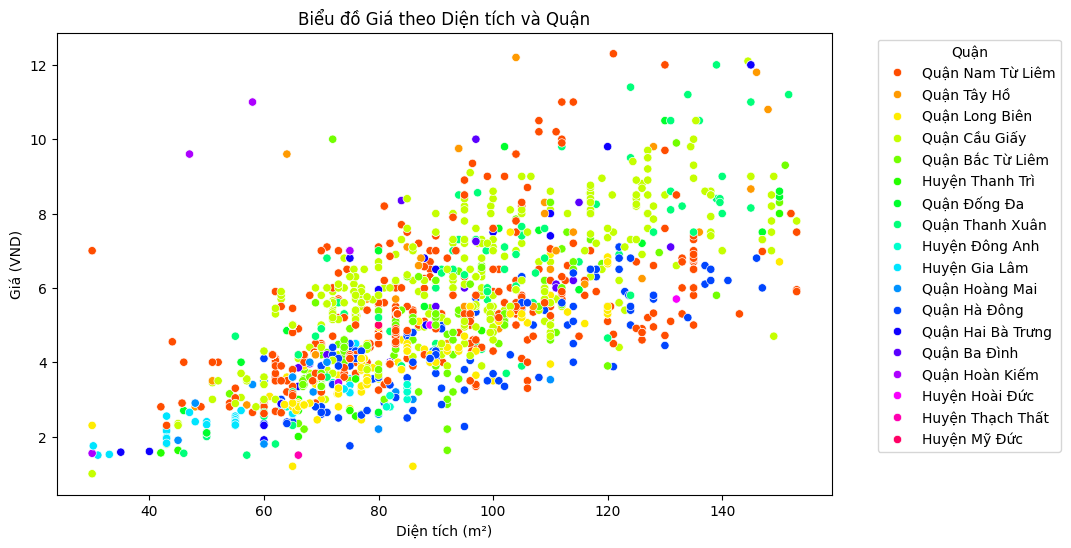

Bảng màu cho các Quận:
Quận Nam Từ Liêm: (1.0, 0.3011032422797128, 0.0)
Quận Tây Hồ: (1.0, 0.6022064845594256, 0.0)
Quận Long Biên: (1.0, 0.9264715147068088, 0.0)
Quận Cầu Giấy: (0.7724252430134786, 1.0, 0.0)
Quận Bắc Từ Liêm: (0.4481602128660953, 1.0, 0.0)
Huyện Thanh Trì: (0.14705697058638245, 1.0, 0.0)
Quận Đống Đa: (0.0, 1.0, 0.1772073369040554)
Quận Thanh Xuân: (0.0, 1.0, 0.47830868224339584)
Huyện Đông Anh: (0.0, 1.0, 0.8025716695319163)
Huyện Gia Lâm: (0.0, 0.8963263319880966, 1.0)
Quận Hoàng Mai: (0.0, 0.5720613018407144, 1.0)
Quận Hà Đông: (0.0, 0.27095805956100094, 1.0)
Quận Hai Bà Trưng: (0.053306970586381903, 0.0, 1.0)
Quận Ba Đình: (0.3544102128660951, 0.0, 1.0)
Quận Hoàn Kiếm: (0.6786752430134784, 0.0, 1.0)
Huyện Hoài Đức: (0.9724261617643972, 0.0, 0.9926476764712057)
Huyện Thạch Thất: (1.0, 0.0, 0.6959564845594255)
Huyện Mỹ Đức: (1.0, 0.0, 0.39485324227971275)


In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_price_by_area_and_district(data):
    # Thiết lập màu sắc cho mỗi quận dựa trên cột 'Quận'
    unique_districts = data['Quận'].unique()
    palette = sns.color_palette("hsv", len(unique_districts))
    district_colors = {district: color for district, color in zip(unique_districts, palette)}
    
    # Vẽ biểu đồ
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Diện tích', y='Giá', hue='Quận', data=data, palette=district_colors)
    
    # Thêm tiêu đề và nhãn cho trục
    plt.title('Biểu đồ Giá theo Diện tích và Quận')
    plt.xlabel('Diện tích (m²)')
    plt.ylabel('Giá (VND)')
    
    # Thêm bảng màu cho các quận
    plt.legend(title='Quận', bbox_to_anchor=(1.05, 1), loc=2)
    
    # Hiển thị biểu đồ
    plt.show()
    
    # In ra bảng mapping màu cho các quận
    print("Bảng màu cho các Quận:")
    for district, color in district_colors.items():
        print(f"{district}: {color}")

# Giả sử bạn đã có DataFrame 'data' với các cột 'Diện tích', 'Giá', 'Quận'
# Ví dụ sử dụng:
plot_price_by_area_and_district(data)


In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Giả sử `data` là DataFrame của bạn với các cột 'Giá', 'Diện tích', và 'Quận'
# data = pd.read_csv('path_to_your_data.csv')

# Tính giá trên mỗi mét vuông
data['Giá trên m2'] = data['Giá'] / data['Diện tích']

# Tính giá trung bình trên mỗi mét vuông cho mỗi quận
average_price_per_area = data.groupby('Quận')['Giá trên m2'].mean().sort_values()

# In kết quả
print(average_price_per_area * 1000)


Quận
Huyện Thạch Thất      22.727273
Huyện Đông Anh        38.898256
Huyện Thanh Trì       40.019472
Quận Hà Đông          46.114654
Huyện Gia Lâm         46.760373
Quận Hoàng Mai        47.857896
Quận Long Biên        48.214928
Huyện Hoài Đức        52.703864
Quận Bắc Từ Liêm      56.673072
Quận Thanh Xuân       62.164710
Huyện Mỹ Đức          62.500000
Quận Hai Bà Trưng     63.020367
Quận Ba Đình          63.096383
Quận Đống Đa          64.279412
Quận Nam Từ Liêm      66.768948
Quận Cầu Giấy         68.855224
Quận Tây Hồ           79.929844
Quận Hoàn Kiếm       104.197342
Name: Giá trên m2, dtype: float64
